In [22]:
from konlpy.tag import Okt
import openpyxl
word_data = []
label_data = []
# 학습용데이터 로드
# f1 = 학습용 문장 / f2 = 학습용 문장의 라벨링

#dataset\\abusive_training_text.txt
#dataset\\slang_training_text.txt
#dataset\\sexual_training_text.txt
f1=open("dataset\\abusive_training_text.txt",'r', encoding='utf-8')
f2=open("dataset\\abusive_training_label.txt",'r', encoding='utf-8')

while True:
    text = f1.readline().rstrip('\n')
    label = f2.readline().rstrip('\n')
    if not text:
        break
    word_data.append(text)
    label_data.append(int(label))

f1.close()
f2.close()

In [23]:
okt=Okt()
morpheme = []

In [24]:
# 문장 형태소 분석, 필요없는 형태소(불용어) 제거 후 저장
for text in word_data:
    mor_data = ""
    for word_tag in okt.pos(text, norm=True, stem=True):
        if word_tag[1] in ['Noun', 'Verb', 'VerbPrefix', 'Adjective', 'Determiner', 'Adverb', 'Exclamation', 'KoreanParticle']:
            mor_data += word_tag[0]
            mor_data += " "
    morpheme.append(mor_data)  

In [25]:
from gensim import models
from gensim.models import FastText

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
# 문장 및 사용될 단어의 최대 길이/갯수 설정
maxlen = 500

In [5]:
ko_vector = models.fasttext.load_facebook_vectors('cc.ko.300.bin')
ko_model = models.fasttext.load_facebook_model('cc.ko.300.bin')

In [26]:
max_words = 2000001
ftTokenizer = Tokenizer(num_words=max_words)
ftTokenizer.fit_on_texts(ko_vector.index2word)
sequences = ftTokenizer.texts_to_sequences(morpheme)
word_index = ftTokenizer.word_index

In [53]:
"""
import json
# 벡터화된 형태소 저장 / 추후 서버에서 호출할 word index 데이터를 json의 형태로 저장
json = json.dumps(word_index)
f3 = open("wordIndex.json", "w")
f3.write(json)
f3.close()
"""

In [27]:
# 문장 별 길이를 동일하게 맞추기 위한 패딩
pad_data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(label_data)

In [28]:
# 현재 데이터들이 욕설x -> 욕설o 순으로 저장되어 있으므로, 배열 순서 셔플
indices = np.arange(pad_data.shape[0])
np.random.shuffle(indices)
text_train = pad_data[indices]
label_train = labels[indices]

In [29]:
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림 - 0.5 이하 = 0 / 0.5 초과 = 1
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정
    # True Positive = 실제 값과 예측 값이 모두 1(Positive)인 경우
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)
    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon() = 'divide by zero error' 예방차원에서 작은 수를 더함
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())
    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림 - 0.5 이하 = 0 / 0.5 초과 = 1
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정
    # True Positive = 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)
    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon() = 'divide by zero error' 예방차원에서 작은 수를 더함
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())
    # return a single tensor value
    return precision

def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    # return a single tensor value
    return _f1score

In [30]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras import regularizers

#순환 컨볼루션 신경망 모델 구축
model = Sequential()
#최대 단어 갯수, 출력백터차수, 입력시퀀스(문장) 길이
#단어를 의미론적 기하고강에 매핑할수 있도록 벡터화
model.add(layers.Embedding(max_words, 32, input_length=maxlen))
#과적합 방지
#0.5 미만 버림
model.add(layers.Dropout(0.5))
#필터를 이용해 지역적인 특징 추출
#출력차원, conv1d 길이, 패딩없음, 은닉층, strides 길이=1
model.add(layers.Conv1D(64, 3, padding='valid', activation='relu', strides=1))
#입력 벡터에서 특정구간마다 값을 골라 벡터구성 후 반환(특징벡터 1/4 화)
model.add(layers.MaxPooling1D(pool_size=4))
#LSTM 
model.add(layers.LSTM(32))
#출력 뉴런 수 = 32, 은닉층
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
#sigmond = 이진분류
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', precision, recall, f1score])  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 32)            64000032  
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 64)            6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)               

In [31]:
# 4회 epoch 시행, 검증데이터 비율 20%
history = model.fit(text_train, label_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
40/40 [==============================] - 23s 579ms/step - loss: 0.6925 - acc: 0.5137 - precision: 0.5123 - recall: 0.9690 - f1score: 0.6669 - val_loss: 0.6907 - val_acc: 0.6062 - val_precision: 0.5637 - val_recall: 0.7454 - val_f1score: 0.6394
Epoch 2/4
40/40 [==============================] - 21s 533ms/step - loss: 0.6623 - acc: 0.5980 - precision: 0.5853 - recall: 0.8999 - f1score: 0.6964 - val_loss: 0.5922 - val_acc: 0.6750 - val_precision: 0.6003 - val_recall: 0.9266 - val_f1score: 0.7271
Epoch 3/4
40/40 [==============================] - 22s 548ms/step - loss: 0.4069 - acc: 0.8520 - precision: 0.8726 - recall: 0.8454 - f1score: 0.8516 - val_loss: 0.3491 - val_acc: 0.8531 - val_precision: 0.9487 - val_recall: 0.7280 - val_f1score: 0.8218
Epoch 4/4
40/40 [==============================] - 22s 544ms/step - loss: 0.2192 - acc: 0.9219 - precision: 0.9502 - recall: 0.8932 - f1score: 0.9199 - val_loss: 0.3447 - val_acc: 0.8813 - val_precision: 0.9328 - val_recall: 0.8041 - val_

In [73]:
'''
from keras.models import load_model
# 서버에서 호출할 모델 저장 및 로드 테스트
model.save('model_c1.h5')
model = load_model('model.h5', custom_objects = {"precision": precision, "recall" : recall, "f1score" : f1score})
'''

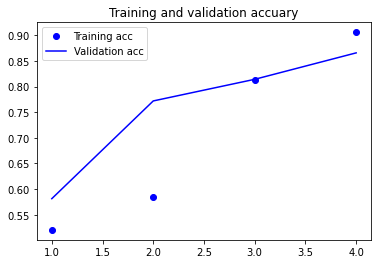

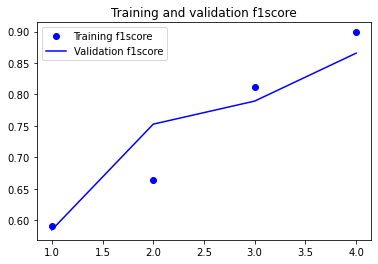

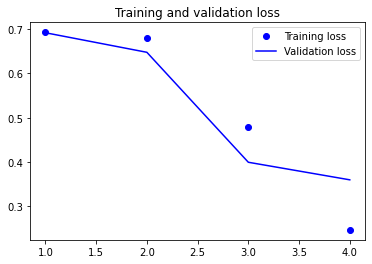

In [66]:
import matplotlib.pyplot as plt
# epoch 결과 비주얼화
#acc
acc = history.history['acc']
val_acc = history.history['val_acc']
#f1score
f1 = history.history['f1score']
val_f1 = history.history['val_f1score']
#loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
#acc - 비주얼화
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuary')
plt.legend()
#f1score - 비주얼화
plt.figure()
plt.plot(epochs, f1, 'bo', label='Training f1score')
plt.plot(epochs, val_f1, 'b', label='Validation f1score')
plt.title('Training and validation f1score')
plt.legend()
#loss - 비주얼화
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [67]:
texts = []
labels = []
# 완성된 모델을 테스트하기 위한 테스트데이터 로드
# f1 = 테스트용 문장 / f2 = 테스트용 문장의 라벨링
f1 = open("800_text.txt", 'r', encoding='utf-8')
f2 = open("800_label.txt", 'r', encoding='utf-8')
while True:
    textline = f1.readline()
    labelline = f2.readline()
    if not textline: break
    texts.append(textline[:-1])
    labels.append(int(labelline[:-1]))
f1.close()
f2.close()

In [68]:
# 문장 형태소 분석, 필요없는 형태소(불용어) 제거 후 저장
morpheme = []
for text in texts:
    mor_data = ""
    for word_tag in okt.pos(text, norm=True, stem=True):
        if word_tag[1] in ['Noun', 'Verb', 'VerbPrefix', 'Adjective', 'Determiner', 'Adverb', 'Exclamation', 'KoreanParticle']:
            mor_data += word_tag[0]
            mor_data += " "
    morpheme.append(mor_data) 

In [70]:
# 정수 인코딩 후 패딩과 셔플
sequences = ftTokenizer.texts_to_sequences(morpheme)
pad_data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
indices = np.arange(pad_data.shape[0])
np.random.shuffle(indices)
text_test = pad_data[indices]
label_test = labels[indices]

In [71]:
#모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1score]) 

In [72]:
_loss, _acc, _precision, _recall, _f1score = model.evaluate(text_test, label_test)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))
print("acc는", round(_acc, 2), "입니다.")
print("f1score는", round(_f1score, 2), "입니다.")

25/25 [==============================] - 0s 3ms/step - loss: 0.3729 - accuracy: 0.8425 - precision: 0.8586 - recall: 0.8278 - f1score: 0.8384
loss: 0.373, accuracy: 0.842, precision: 0.859, recall: 0.828, f1score: 0.838
acc는 0.84 입니다.
f1score는 0.84 입니다.
